In [1]:
## DeepExplain - Keras (TF backend) example
### MNIST with CNN
%load_ext autoreload
%autoreload 2

In [ ]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np
import tensorflow as tf
import scipy

# Import DeepExplain
from deepexplain.tensorflow import DeepExplain, ProbDense, ProbDense, ProbActivationRelu

#Import DeepLift
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

from math import pi
from scipy.special import erf, erfc
exp = np.exp
def rect_mean(mus, vs):
    assert mus.shape == vs.shape
    m = mus
    v = vs
    s = v**0.5
    r1 = s*exp(-(m**2)/(2*v))/(2*pi)**0.5
    r2 = 0.5*m*(1+erf(m/((2*v)**0.5)))
    return r1 + r2


def rect_var(mus, vs):
    assert mus.shape == vs.shape
    m = mus
    v = vs
    s = v**0.5
    r1 = -v*exp(-(m**2)/v)/(2*pi)
    r2 = (-m*s*erf(m/(2*v)**0.5)*exp(-(m**2)/(2*v)))/(2*pi)**0.5
    r3 = -0.25*(-2+erfc(m/(2*v)**0.5))*(2*v + m**2 *erfc(m/(2*v)**0.5))
    return r1+r2+r3
print (keras.__version__)

In [3]:
# Build and train a network.

SKIP_TRAIN = False
saved_model_file = 'model.h5'
saved_model_weights_file = 'model_w.h5'

batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 4, 4

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_train])
x_test = np.array([scipy.misc.imresize(x, (img_rows,img_cols,)) for x in x_test])



#x_train = x_train.reshape(-1, 28,28,1)
#x_test = x_test.reshape(-1, 28,28,1)
x_train = x_train.reshape(-1, img_rows*img_cols)
x_test = x_test.reshape(-1, img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train = (x_train - 0.5) * 2
x_test = (x_test - 0.5) * 2
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
reg = keras.regularizers.l2(0)
def f(x):
    return x*tf.sigmoid(x)

if SKIP_TRAIN:
    model = load_model(saved_model_file)
else:
    #de.enable_override('shapley')
    model = Sequential()
    model.add(Dense(256, input_shape=(img_rows*img_cols,), activation='relu', kernel_regularizer=reg, name='dens_1'))
    model.add(Dense(128, activation='relu', kernel_regularizer=reg, name='dens_2'))
    model.add(Dense(num_classes, kernel_regularizer=reg, name='dens_3'))
    model.add(Activation('softmax'))
    # ^ IMPORTANT: notice that the final softmax must be in its own layer 
    # if we want to target pre-softmax units

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    model.save(saved_model_file)
    model.save_weights(saved_model_weights_file)

    print (model.layers[0].get_weights()[1].mean())
    print (model.layers[0].get_weights()[1].var())
    
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


x_train shape: (60000, 16)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 22us/step - loss: 1.2566 - acc: 0.5822 - val_loss: 0.8640 - val_acc: 0.7239
Epoch 2/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.7293 - acc: 0.7629 - val_loss: 0.6381 - val_acc: 0.7980
Epoch 3/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.6091 - acc: 0.7999 - val_loss: 0.5732 - val_acc: 0.8080
Epoch 4/10
60000/60000 [==============================] - 1s 14us/step - loss: 0.5474 - acc: 0.8202 - val_loss: 0.5341 - val_acc: 0.8231
Epoch 5/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.5073 - acc: 0.8325 - val_loss: 0.4787 - val_acc: 0.8445
Epoch 6/10
60000/60000 [==============================] - 1s 15us/step - loss: 0.4771 - acc: 0.8436 - val_loss: 0.4463 - val_acc: 0.8537
Epoch 7/10
60000/60000 [==============================] - 1s 1

In [4]:
xs = x_test[0:3]
ys = y_test[0:3]

In [24]:
%%time
features = img_rows*img_cols
n_classes = 10

# Get weights of first dense
weights = model.layers[0].get_weights()
kernel = weights[0]
bias = weights[1]
n_output_feat = kernel.shape[1]

# Create an equivalent probabilistic model. Notice that
# 1. The (probabilistic) input has one more dimension to include both mean and variance
# 2. We only keep the non-linearity of the original first dense layer (because the probabilistic input will be computed aside)
probInput = Input(shape=(n_output_feat, 2))
y = ProbActivationRelu()(probInput)
y = ProbDense(128, activation='relu', name='dens_2')(y)
y = ProbDense(num_classes, name='dens_3')(y)
probModel = Model(inputs=probInput, outputs=y)
# ... and load weights in it
probModel.load_weights(saved_model_weights_file, by_name=True)

# Implement loop to estimate shapley values
# Params
xn = 50

# Flatten MNIST input
x = np.copy(xs.reshape(xs.shape[0], -1))
# Prepare array for output
result = np.zeros(x.shape + (n_classes,))
# Count how many input features are there
n_input_feat = x.shape[1]
# Define sub-coalition sizes
Ks = range (0, n_input_feat, max(1, n_input_feat//xn))

for j in range(n_input_feat):
    for ki in range(len(Ks)):
        k = Ks[ki] # coalition size
    
        x_i = x.copy()
        x_i[:, j] = 0
        # Dense is essentially a dot product.
        # Here, instead of 1, we do 3 dot products
        dot = np.dot(x, kernel)
        dot_i = np.dot(x_i, kernel)
        dot_v = np.dot(x_i ** 2, kernel ** 2)
        # Compute mean without feature i
        mu = dot_i / (n_input_feat - 1)
        # Compensate for number of players in current coalition
        mu1 = mu * k
        # Compute mean of the distribution that also includes player i (acting as bias to expectation)
        mu2 = mu1 + (dot - dot_i)
        # Compute variance without player i
        v1 = dot_v / (n_input_feat - 1) - mu**2
        # Compensate for number or players in the coalition
        v1 = v1 * k
        # Set something different than 0 if necessary
        v1 = np.maximum(0.00001, v1)
        # Since player i is only a bias, at this point the variance of the distribution than
        # includes it is the same
        v2 = v1
        
        mu1 += bias
        mu2 += bias
        
        x1 = np.stack([mu1, v1], -1)
        x2 = np.stack([mu2, v2], -1)
        out1 = probModel.predict(x1)
        out2 = probModel.predict(x2)
        eshap = ((out2[..., 0] - out1[..., 0]) / len(Ks))
        result[:, j, :] += eshap

print (result.shape)
print (np.argmax(ys, 1).shape)
a_shap = np.array([result[i, :, c] for i, c in enumerate(np.argmax(ys, 1))])
print (a_shap.shape)
print ('Done')


(3, 16, 10)
(3,)
(3, 16)
Done
CPU times: user 792 ms, sys: 32 ms, total: 824 ms
Wall time: 630 ms


In [6]:
%time
with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    # Need to reconstruct the graph in DeepExplain context, using the same weights.
    # With Keras this is very easy:
    # 1. Get the input tensor to the original model
    input_tensor = model.layers[0].input
    
    # 2. We now target the output of the last dense layer (pre-softmax)
    # To do so, create a new model sharing the same layers untill the last dense (index -2)
    fModel = Model(inputs=input_tensor, outputs = model.layers[-2].output)
    target_tensor = fModel(input_tensor)
    

    
    a_gradin = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('saliency', target_tensor * ys, input_tensor, xs)
    a_intgrad = de.explain('intgrad', target_tensor * ys, input_tensor, xs)
    a_res = de.explain('deeplift', target_tensor * ys, input_tensor, xs)
    a_rc = de.explain('deeplift_rc', target_tensor * ys, input_tensor, xs)
    #a_linear = de.explain('linear', target_tensor * ys, input_tensor, xs)
    a_layershap = de.explain('shapley', target_tensor * ys, input_tensor, xs)
    #a_shap = np.zeros_like(a_linear)
    
    #attributions2 = de.explain('elrp', target_tensor * ys, input_tensor, xs)
    #attributions = de.explain('occlusion', target_tensor * ys, input_tensor, xs)
    print ("Done")

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.25 µs
DeepExplain: running "grad*input" explanation method (2)
Model with multiple inputs:  False
DeepExplain: running "intgrad" explanation method (3)
Model with multiple inputs:  False
DeepExplain: running "deeplift" explanation method (5)
Model with multiple inputs:  False
DeepLIFT: computing references...
DeepLIFT: references ready
DeepExplain: running "deeplift_rc" explanation method (6)
Model with multiple inputs:  False
Shapley: computing references...
Applying DeepShap on the following ops:  dict_keys(['model_2/dens_1/MatMul', 'model_2/dens_2/MatMul'])
revcancel
model_2/dens_3/MatMul uses original gradient
revcancel
Eta shap [revcancel] games[(3, 256, 128)], bias[(128,)], baseline[(3, 256, 128)]
Reshape: games[(3, 256, 128)], bias[(128,)], baseline[(3, 256, 128)]
revcancel
Eta shap [revcancel] games[(3, 16, 256)], bias[(256,)], baseline[(3, 16, 256)]
Reshape: games[(3, 16, 256)], bias[(256,)], baseline[(3, 16, 256)]
Deep

/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:413: RuntimeWarning: divide by zero encountered in true_divide
  t = (i / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:414: RuntimeWarning: divide by zero encountered in true_divide
  tb = (ib / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:420: RuntimeWarning: overflow encountered in square
  exp1 = e ** -(t ** 2)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:421: RuntimeWarning: overflow encountered in square
  exp2 = e ** -(tb ** 2)
/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:453: RuntimeWarning: invalid value encountered in true_divide
  eta =  np.where(np.abs(deltas) > 1e-6, shap / deltas, np.zeros_like(shap))


None
Eta shap [approx] games[(3, 16, 256)], bias[(256,)], baseline[(3, 16, 256)]
Reshape: games[(3, 16, 256)], bias[(256,)], baseline[(3, 16, 256)]
Done


/home/anconam/projects/DeepExplain/deepexplain/tensorflow/deep_shapley.py:414: RuntimeWarning: invalid value encountered in true_divide
  tb = (ib / (2 * vars[:, :, np.newaxis] * Xs[np.newaxis, np.newaxis, :]) ** 0.5)


In [7]:
# Compute exacly shapley values!
saved_file = 'exact.npy'
a_exact = np.zeros_like(a_gradin)
if True or not SKIP_TRAIN:
    from deepexplain.tensorflow.exact_shapley import compute_shapley
    a_exact = np.array([compute_shapley(xx, lambda x: (fModel.predict(np.array(x))*yy).sum(-1)) for xx, yy in zip(xs, ys)])
    np.save(saved_file, a_exact)
else:
    a_exact = np.load(saved_file)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:24: UserWarning:

The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning:

Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.



Text(0.5, 1.0, 'Exact Shap')

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:395: UserWarning:


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:396: UserWarning:


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:403: UserWarning:


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:408: UserWarning:


/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:902: UserWarning:


/usr/local/lib/python3.6/dist-packages/numpy/ma/core.py:716: UserWarning:




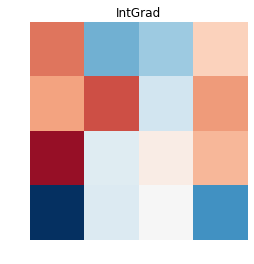

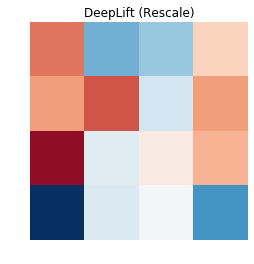

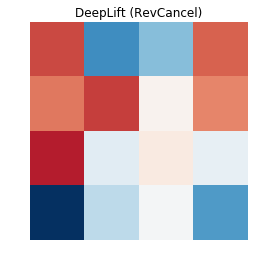

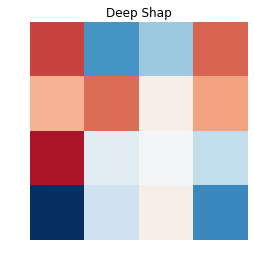

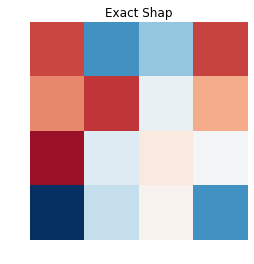

In [15]:
# Plot attributions
from utils import plot, plt
%matplotlib inline
idx = 1
# plot(a_gradin[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('GradInput')
# plt.figure()
plot(a_intgrad[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('IntGrad')
plt.figure()
plot(a_res[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (Rescale)')
#plt.figure()
#plot((a_linear)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Linear')
plt.figure()
plot(a_rc[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('DeepLift (RevCancel)')
plt.figure()
plot((a_shap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Deep Shap')
plt.figure()
# plot((a_layershap)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Layerwise Shap')
# plt.figure()
#plot((a_shaplud)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('SHAP')
#plt.figure()
plot((a_exact)[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Exact Shap')


        
        


MSE with DeepShap  0.2288700994484291
MSE with DeepLift  0.2927836199298476
MSE with DeepLift (Rescale)  4.615019473966188
MSE with Int Gradients  4.8594098514479045
MSE with GradInput  13.516095859856755
Kendall corr.  with DeepShap  0.9277777777777777
Kendall corr.  with DeepLift  0.9500000000000001
Kendall corr.  with DeepLift (rescale) 0.8388888888888889
Kendall corr.  with Int Gradients  0.8277777777777778
Kendall corr.  with GradInput  0.7000000000000001


<Figure size 432x288 with 0 Axes>

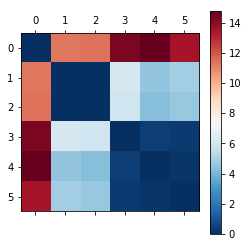

<Figure size 432x288 with 0 Axes>

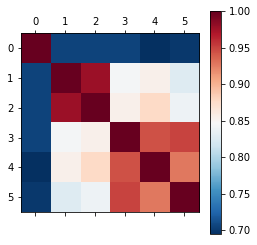

In [25]:
methods = [a_gradin, a_intgrad, a_res, a_rc, a_shap, a_exact]
confusion = np.zeros((len(methods), len(methods)))
confusion[:] = np.nan
confusion_r = np.zeros((len(methods), len(methods)))
confusion_r[:] = np.nan

n = a_gradin.shape[0]
for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        if i >= j:
            m1 = m1.reshape(n, -1)
            m2 = m2.reshape(n, -1)
            confusion[i][j] = ((m1-m2)**2).mean()
            confusion_r[i][j] = np.mean([scipy.stats.kendalltau(x, y)[0] for x,y in zip(m1, m2)])
            confusion[j][i] = confusion[i, j]
            confusion_r[j][i] = confusion_r[i, j]
plt.figure()
plt.matshow(confusion, cmap='RdBu_r')
plt.colorbar()
plt.figure()
plt.matshow(confusion_r, cmap='RdBu_r')
plt.colorbar()
#print ('MSE with SHAP ', confusion[-1][-2])
comparison = -1
print ('MSE with DeepShap ', confusion[-2][comparison])
print ('MSE with DeepLift ', confusion[-3][comparison])
print ('MSE with DeepLift (Rescale) ', confusion[-4][comparison])
print ('MSE with Int Gradients ', confusion[-5][comparison])
print ('MSE with GradInput ', confusion[-6][comparison])

#print ('Kendall corr. with SHAP ', confusion_r[-1][-2])
print ('Kendall corr.  with DeepShap ', confusion_r[-2][comparison])
print ('Kendall corr.  with DeepLift ', confusion_r[-3][comparison])
print ('Kendall corr.  with DeepLift (rescale)', confusion_r[-4][comparison])
print ('Kendall corr.  with Int Gradients ', confusion_r[-5][comparison])
print ('Kendall corr.  with GradInput ', confusion_r[-6][comparison])

In [10]:
from deepexplain.tensorflow.accuracy_robustness import run_robustness_test
original_maps = [a_gradin, a_intgrad, a_res, a_rc, a_shap]
names = ['GradInput', 'IntGrad', 'DeepLift (Recale)', 'DeepLift (RevCanc)', 'Deep Shapley']
run_robustness_test(fModel, xs, ys, original_maps, names, 'Test', 1,
                        result_path='.', mode='prediction', reduce_dim=None)



Running robustness test...
Storing robustness results...
Done


In [11]:
from deepexplain.tensorflow.sensitivityn import run_sensitivity_test
run_sensitivity_test(fModel, xs, ys, original_maps, names, 'Test',
                        result_path='.', number_of_samples=1000)


Running delta test...
Done





In [12]:
%%script false

# Compute DeepLift attributions
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
rescale_model = kc.convert_model_from_saved_files(
                            h5_file=saved_model_file,
                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)

revealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)
rescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)

a_rc = np.array([np.array(revealcancel_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])

a_res = np.array([np.array(rescale_func(
                task_idx=np.argmax(y),
                input_data_list=[[x]],
                input_references_list=[[np.zeros_like(x)]],
                batch_size=100,
                progress_update=None)) for x, y in zip(xs,ys)])
print (a_rc.shape)

CalledProcessError: Command 'b'\n# Compute DeepLift attributions\nrevealcancel_model = kc.convert_model_from_saved_files(\n                            h5_file=saved_model_file,\n                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)\nrescale_model = kc.convert_model_from_saved_files(\n                            h5_file=saved_model_file,\n                            nonlinear_mxts_mode=NonlinearMxtsMode.Rescale)\n\nrevealcancel_func = revealcancel_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)\nrescale_func = rescale_model.get_target_contribs_func(find_scores_layer_idx=0, target_layer_idx=-2)\n\na_rc = np.array([np.array(revealcancel_func(\n                task_idx=np.argmax(y),\n                input_data_list=[[x]],\n                input_references_list=[[np.zeros_like(x)]],\n                batch_size=100,\n                progress_update=None)) for x, y in zip(xs,ys)])\n\na_res = np.array([np.array(rescale_func(\n                task_idx=np.argmax(y),\n                input_data_list=[[x]],\n                input_references_list=[[np.zeros_like(x)]],\n                batch_size=100,\n                progress_update=None)) for x, y in zip(xs,ys)])\nprint (a_rc.shape)\n'' returned non-zero exit status 1.

In [ ]:
# Randomization test
original_attribution = a_shap
heatmaps = []
the_model = probModel
original_weights = {}
attribute_f = compute_deepshap

plt.figure()
plot(original_attribution[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Original')

for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        original_weights[i] = l.get_weights()
        # Replace weights with random
        new_weights = [np.random.normal(size=w.shape) for w in l.get_weights()]
        l.set_weights(new_weights)
        print (i, l)
        a = attribute_f()
        plt.figure()
        plot(a[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title(str(i))
        heatmaps.append(a)
        
        
# Restore weights
for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        l.set_weights(original_weights[i])

print ("Correlations")
for attr in heatmaps:
    corr = np.mean([scipy.stats.spearmanr(x.flatten(), y.flatten())[0] for x,y in zip(original_attribution, attr)])
    print (corr)

In [ ]:
# Randomization test
original_attribution = a_gradin
heatmaps = []
the_model = fModel
original_weights = {}
print (original_attribution.shape)

plt.figure()
plot(original_attribution[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title('Original')

with DeepExplain(session=K.get_session()) as de:  # <-- init DeepExplain context
    for i, l in enumerate(the_model.layers[::-1]):
        if (len(l.get_weights())):
            original_weights[i] = l.get_weights()
            # Replace weights with random
            new_weights = [np.random.normal(size=w.shape) for w in l.get_weights()]
            l.set_weights(new_weights)
            print (i, l.get_weights()[0].shape)
            a = de.explain('grad*input', target_tensor * ys, input_tensor, xs)
            plt.figure()
            plot(a[idx].reshape(img_rows, img_cols), xs[idx].reshape(img_rows, img_cols)).title(str(i))
            #print (a[idx])
            heatmaps.append(a)
        
        
# Restore weights
for i, l in enumerate(the_model.layers[::-1]):
    if (len(l.get_weights())):
        l.set_weights(original_weights[i])

print ("Correlations")
for attr in heatmaps:
    corr = np.mean([scipy.stats.spearmanr(x.flatten(), y.flatten())[0] for x,y in zip(original_attribution, attr)])
    print (corr)